In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-plot
from tensorflow import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import os

## **1. Experimental Codes**

In [ ]:
xtrain = []
ytrain = []

data_path = '/content/drive/MyDrive/data_mel_all'

count = 1
for sub in os.scandir(data_path):
  for class_dir  in os.scandir(sub):
    for a in os.scandir(class_dir):
      if os.path.isfile(a):
        xtrain.append(cv2.imread(a.path, 0))
        ytrain.append(class_dir.name)
        print('load : ','[',count,']')
        count += 1

NameError: ignored

In [ ]:
xtest = []
ytest = []

data_path = '/content/drive/MyDrive/eval_mel'

count = 1
for class_dir  in os.scandir(data_path):
  for a in os.scandir(class_dir):
    if os.path.isfile(a):
      xtest.append(cv2.imread(a.path, 0))
      ytest.append(class_dir.name)
      print('load : ','[',count,']')
      count += 1

NameError: ignored

In [ ]:
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [ ]:
xtest = np.array(xtest)
ytest = np.array(ytest)

In [ ]:
xtrain = xtrain/255

In [ ]:
xtest = xtest/255

In [ ]:
plt.imshow(xtest[0,:,:])

In [ ]:
np.save('xtest.npy',xtest)
np.save('ytest.npy',ytest)

In [ ]:
xtrain = np.load('/content/drive/MyDrive/train_set/xtrain.npy')
ytrain = np.load('/content/drive/MyDrive/train_set/ytrain.npy')
xtest = np.load('/content/drive/MyDrive/train_set/xtest.npy')
ytest = np.load('/content/drive/MyDrive/train_set/ytest.npy')

In [ ]:
classes = {'1_Gunshot_m032s66_':1,'Gunshot':1, '2_Explosion_m014zdl_m0_1c_':2,'Explosion':2, '3_Car_Alarm_m02mfyn_':3,'Car Alarm':3, 'Interior_alarm':4,'Interior_Alarm':4, 'Siren':5, 'Screaming':6, 'Crying':7, 'Barking':8, 'Noise':9}

In [ ]:
def one_hot(ytrain):
  max_class = np.max(ytrain)
  onehot = np.zeros((ytrain.shape[0], max_class))
  for yt, oh in zip(ytrain, list(range(onehot.shape[0]))):
    onehot[oh, yt-1] = 1
  return onehot

In [ ]:
xtrain = np.expand_dims(xtrain, -1)
xtrain = np.concatenate((xtrain,xtrain,xtrain), 3)
ytrain_num = np.array([classes[i] for i in ytrain])
ytrain_onehot = one_hot(ytrain_num)

In [ ]:
xtest = np.expand_dims(xtest, -1)
xtest = np.concatenate((xtest,xtest,xtest), 3)
ytest_num = np.array([classes[i] for i in ytest])
ytest_onehot = one_hot(ytest_num)

In [ ]:
model = tf.keras.applications.DenseNet201(include_top=True, weights=None , input_shape=xtest[0].shape, classes=9)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/binary_model/Crying/DenseNet201_4_epoches_val_loss: 0.1674 - val_accuracy: 0.9404')

In [ ]:
model.fit(xtrain, ytrain_onehot, epochs=1, batch_size=1,validation_data=(xtest,  ytest_onehot),verbose=1)

In [ ]:
model.save('Xception_20_epoches_val_acc_0.4038.h5')

In [ ]:
img = []
for i in os.scandir('/content/drive/MyDrive/Noise_mel'):
  if os.path.isfile(i):
    img.append(cv2.imread(i.path, 0)/255.)
img = np.expand_dims(img, -1)
img = np.concatenate((img,img,img),axis=-1)
img = np.array(img)

In [ ]:
noise_pred = model.predict(img)

In [ ]:
ypred = model.predict(xtest)

In [ ]:
n_p = noise_pred.argmax(axis=1)
cname = [class_list[i] for i in n_p]

In [ ]:
n_y = ypred.argmax(axis=1)
cname_y = [class_list[i] for i in n_y]

In [ ]:
high_prob_y = [a[i] for a,i in zip(ypred, n_y)]
high_prob_noise = [a[i] for a,i in zip(noise_pred, n_p)]

In [ ]:
min(high_prob_y)
min(high_prob_noise)
high_prob_y
# for i,j in zip(cname, high_prob_noise):
#   print(i,j)
print(np.mean(high_prob_noise),np.mean(high_prob_y))

In [ ]:
count = 0
pred = model.predict(xtest)
for i,j in zip(pred,ytest_onehot):
  if i.argmax() == j.argmax():
    count += 1
print(count/len(pred))

In [ ]:
count = 0
pred = model.predict(xtrain)
for i,j in zip(pred,ytrain_onehot):
  if i.argmax() == j.argmax():
    count += 1
print(count/len(pred))

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/binary_model/Barking/DenseNet201_15_epoches_val_loss: 0.0990 - val_accuracy: 0.9756')

In [ ]:
model.save('/content/drive/MyDrive/model_4/DenseNet201_Unbalanced14K_Noises_CONV2temp_12_epoches_batch32_val_loss: 1.1273 - val_accuracy: 0.7846.h5')

In [ ]:
import cv2
img = cv2.imread('/content/meltest.png',0)
img = img/255

In [ ]:
shape = (431, 128)
img = cv2.resize(img, shape, cv2.INTER_AREA)

In [ ]:
a = model.predict(np.array([np.dstack((img,img,img))]))
class_list[a[0].argmax()]

In [ ]:
plt.imshow(img, cmap = 'gray')

## **2. Training Binary Model**

### **2.1 Create a CNN binary classifier model**

In [ ]:
model = tf.keras.applications.DenseNet201(include_top=True, weights=None , input_shape=(128,128,3), classes=10)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

### **2.2 Create DataGenerator objects for training and testing**

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/model_4/DenseNet201_Unbalanced14K_NEW_CONV2_16_epoches_loss: 0.9654 - accuracy: 0.7509.h5')

In [ ]:
from keras.utils.np_utils import to_categorical   

# Define the class name (must be corresponded to folder name of each class)
class_list = os.listdir(XXX) #class name from train folder
# class_list = ['Gunshot', 'Explosion','Car Alarm','Interior_Alarm','Siren', 'Screaming', 'Crying','Barking','Noise']

# Normalize image function
load_func = lambda x:x/255

datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=load_func)

# Train and test folder (including sub folders for each class above)
train_path = XXX
test_path = XXX

# Image size
target_size = (300, 300)

# load and iterate training dataset
train_it = datagen.flow_from_directory(train_path, class_mode='categorical', batch_size=16,target_size=target_size,classes=class_list,shuffle=True)
#FALSE SHUFFLEEE____________________++++++++++++++++++
test_it  = datagen.flow_from_directory(test_path, class_mode='categorical', batch_size=1,target_size=target_size,classes=class_list,shuffle=False)

Found 22729 images belonging to 9 classes.
Found 1393 images belonging to 9 classes.


### **2.3 Change the labels of data**
- Specify the class index that we interest from class_list (0-7)
- The specified class will be re-labeled to 1
- The rest of the classes will be re-labeled to 0

**This cell will be used instead of the cell above IF THE CLASS INDEX IS ZERO! (0)**

### **2.4 Fit the model**

In [ ]:
model.fit(train_it,epochs=30, validation_data=test_it,verbose=1,workers=8)

Epoch 1/6
1421/1421 [==============================] - 508s 357ms/step - loss: 0.2285 - accuracy: 0.8909 - val_loss: 0.5615 - val_accuracy: 0.7688
Epoch 2/6
1421/1421 [==============================] - 509s 358ms/step - loss: 0.2144 - accuracy: 0.8974 - val_loss: 1.0424 - val_accuracy: 0.6368
Epoch 3/6
1421/1421 [==============================] - 507s 357ms/step - loss: 0.2125 - accuracy: 0.8996 - val_loss: 0.5151 - val_accuracy: 0.8141
Epoch 4/6
1421/1421 [==============================] - 507s 356ms/step - loss: 0.1972 - accuracy: 0.9022 - val_loss: 1.0451 - val_accuracy: 0.6475
Epoch 5/6
1421/1421 [==============================] - 507s 357ms/step - loss: 0.1905 - accuracy: 0.9069 - val_loss: 0.2095 - val_accuracy: 0.9196
Epoch 6/6
1421/1421 [==============================] - 508s 357ms/step - loss: 0.1934 - accuracy: 0.9056 - val_loss: 0.3448 - val_accuracy: 0.8629


**Set a new learning rate..**

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00003)

In [ ]:
model.save('/content/drive/MyDrive/binary_model/Gunshot/DenseNet201_16_epoches_val_loss: 0.3448 - val_accuracy: 0.8629.h5')

### **2.5 Evaluate the model and show reports**

In [ ]:
from tqdm import tqdm
file_names = []
test_it.reset()
X_test, y_test = next(test_it,6)
file_names.append(test_it.filenames[0])
for i in tqdm(range(int(len(test_it)/1)-1)):
  img, label = next(test_it,6)
  file_names.append(test_it.filenames[i+1])
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 1392/1392 [10:11<00:00,  2.28it/s]

(1393, 128, 431, 3) (1393, 9)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


,precision,recall,f1-score,support
Gunshot,0.791667,0.539007,0.641350,141.000000
Explosion,0.481481,0.565217,0.520000,92.000000
Car Alarm,0.425926,0.469388,0.446602,49.000000
Interior_Alarm,0.800000,0.677966,0.733945,118.000000
Siren,0.859060,0.699454,0.771084,183.000000
Screaming,0.340000,0.404762,0.369565,42.000000
Crying,0.590361,0.720588,0.649007,68.000000
Barking,0.842105,0.640000,0.727273,50.000000
Noise,0.823776,0.906154,0.863004,650.000000
accuracy,0.750897,0.750897,0.750897,0.750897


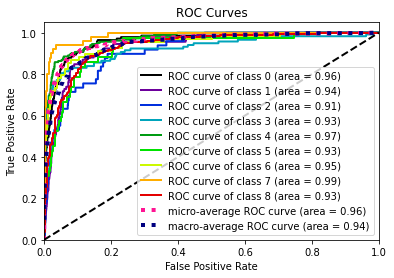

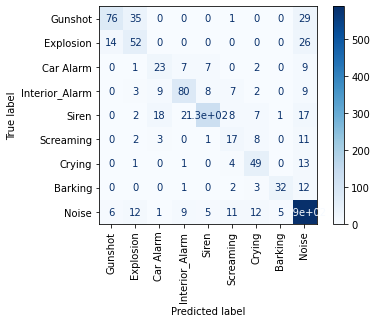

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier


Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(X_test)
Y_pred = np.argmax(y_pred, axis=1)

skplt.metrics.plot_roc_curve(y_true =  Y_test,y_probas= y_pred,)

a = confusion_matrix(Y_test, Y_pred)

class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y,axis=1)

disp = plot_confusion_matrix(newmodel(model), X_test, Y_test,
                                 display_labels=list(test_it.class_indices.keys()),
                                 cmap=plt.cm.Blues,xticks_rotation='vertical')
# disp = plot_confusion_matrix(newmodel(model), X_test, Y_test,
#                                  display_labels=['0','1'],
#                                  cmap=plt.cm.Blues,xticks_rotation='vertical')
df = pd.DataFrame.from_dict(classification_report(Y_test, Y_pred,target_names=list(test_it.class_indices.keys()),output_dict=True))
# df = pd.DataFrame.from_dict(classification_report(Y_test, Y_pred,output_dict=True))

df.transpose()
# print(test_it.class_indices)

### IRRELEVANT CODE

In [ ]:
pred_noise = model.predict(X_test)

In [ ]:
pred_noise = pred_noise.argmax(axis=1)

In [ ]:
file_names = np.array(file_names)

In [ ]:
plabel = np.array([class_list[i] for i in pred_noise])
scream = plabel == 'Screaming'
cry = plabel == 'Crying'
scream_cry = scream | cry
# X_t = X_test[Y_test == 8]
file_names[scream_cry]

In [ ]:
from IPython.display import Audio
import librosa as lr
Audio(filename='/content/drive/MyDrive/Clapping/-DoI-3Hjx-Q.wav')

FileNotFoundError: ignored

In [ ]:
model.evaluate(train_it)

6111/6111 [==============================] - 82s 13ms/step - loss: 2.5070 - accuracy: 0.6010


[2.5069825649261475, 0.6010472774505615]

In [ ]:
model.evaluate(test_it)

1393/1393 [==============================] - 50s 36ms/step - loss: 0.9654 - accuracy: 0.7509


[0.9654493927955627, 0.7508973479270935]

In [ ]:
model.save('DenseNet201_Unbalanced14K_NEW_CONV2_16_epoches_loss: 0.9654 - accuracy: 0.7509.h5')

In [ ]:
test_it.class_indices

{'Barking': 7,
 'Car Alarm': 2,
 'Crying': 6,
 'Explosion': 1,
 'Gunshot': 0,
 'Interior_Alarm': 3,
 'Screaming': 5,
 'Siren': 4}

In [ ]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

Found TPU at: grpc://10.8.140.130:8470


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = tf.keras.models.load_model('/content/drive/MyDrive/model/RestNet50_UnbalancedV1_31_epoches_val_acc_0.5236.h5')
  model.fit(train_it,epochs=5, validation_data=test_it,verbose=1)



In [ ]:
!nvidia-smi

Tue Jun 22 04:30:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    78W / 149W |   5370MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **TF Graph**

In [ ]:
a = []
b = []
from tensorflow.python.platform import gfile
with tf.compat.v1.Session() as sess:
    with gfile.FastGFile('/content/drive/MyDrive/model_3/DenseNet201/frozen_graph.pb', 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)
    for op in tf.compat.v1.get_default_graph().get_operations():
        a.append(str(op.name))
    for n in tf.compat.v1.get_default_graph().as_graph_def().node:
        b.append(n.name)

In [ ]:
list(filter(lambda x : 'input' in x ,b))

['import/serving_default_input_2', 'import_1/serving_default_input_2']

In [ ]:
from tensorflow.python.platform import gfile
with tf.compat.v1.Session() as sess:
    with gfile.FastGFile('/content/drive/MyDrive/model_3/DenseNet201/frozen_graph.pb', 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)
    tensor_output = sess.graph.get_tensor_by_name('import_4/densenet201/predictions/Softmax:0')
    tensor_input = sess.graph.get_tensor_by_name('import_4/x:0')
    predictions = sess.run(tensor_output, {tensor_input:xtest[500:505].astype(np.float32) })
    print(predictions)

[[7.10793837e-12 1.27291092e-12 1.63391587e-06 9.99994755e-01
  3.58220791e-06 1.38339375e-11 1.19577945e-13 3.47587070e-10]
 [5.08302124e-04 1.79361406e-04 1.54462672e-04 9.67289031e-01
  3.12087666e-02 6.28443231e-05 1.11566233e-05 5.86043694e-04]
 [5.99822309e-03 6.76208362e-03 4.34710272e-03 1.98711511e-02
  2.96433400e-02 6.78911339e-04 8.83744564e-04 9.31815445e-01]
 [1.59248927e-07 2.11278734e-06 8.93315446e-05 9.98267174e-01
  1.63161999e-03 8.07902961e-06 3.47678053e-07 1.12387158e-06]
 [7.45489786e-04 8.33424492e-05 6.32749288e-05 9.96088862e-01
  2.89452402e-03 6.88014406e-05 1.68661711e-06 5.40249675e-05]]


In [ ]:
predictions = predictions.argmax(axis = 1)
predictions

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/model_2/DenseNet201_Unbalanced14K_xx_epoches_val_loss: 1.0203 - val_accuracy: 0.7254.h5')

In [ ]:
model.save('/content/drive/MyDrive/model_3/DenseNet201/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_3/DenseNet201/assets


In [ ]:
layer_names=[layer.name for layer in model.layers]

In [ ]:
import tensorflow as tf
import sys
from tensorflow.python.platform import gfile
from tensorflow.core.protobuf import saved_model_pb2
from tensorflow.python.util import compat

with tf.compat.v1.Session() as sess:
    model_filename ='/content/drive/MyDrive/model_3/DenseNet201/saved_model.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        g_in = tf.import_graph_def(sm.meta_graphs[0].graph_def)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
#path of the directory where you want to save your model
frozen_out_path = ''
# name of the .pb file
frozen_graph_filename = 'frozen_graph'
model = model
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

NameError: ignored

tensorflow.core.protobuf.meta_graph_pb2.MetaGraphDef

In [ ]:
!nvidia-smi

Mon Jul 12 06:49:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |    348MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------